In [1]:
#Run this if you want to force to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-12-11 01:48:59.890529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 01:48:59.953112: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-11 01:48:59.955068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 01:49:01.101122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-12-11 01:49:03.444221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-11 01:49:03.444255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA d

2025-12-11 01:49:04.675924: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2025-12-11 01:49:06.468823: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2025-12-11 01:49:07.020117: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2025-12-11 01:49:07.796617: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2025-12-11 01:49:08.273701: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.



=== Resumen ===
      model                                  path  exists  filesize_bytes  loaded  params_count  weights_total  weights_zeros  sparsity_fraction  eval_loss  eval_accuracy  inference_time_total_s  inference_time_per_sample_ms
    student    models/MLP/studentModelMnistMLP.h5    True          234392    True         52650          52650          26272           0.498993   0.396954         0.8848                0.446930                      0.044693
    teacher    models/MLP/teacherModelMnistMLP.h5    True         1305936    True        105990         105990              0           0.000000   0.165111         0.9675                0.197919                      0.019792
teacher_qat models/MLP/teacherModelQATMnistMLP.h5    True         1312488    True        105990         105990              0           0.000000   0.442293         0.8787                0.438666                      0.043867


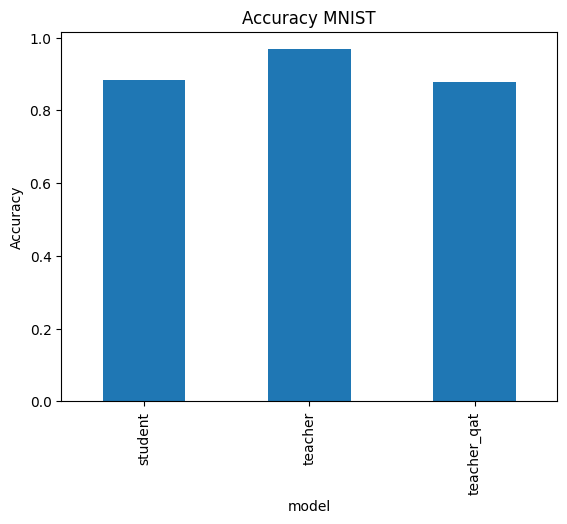

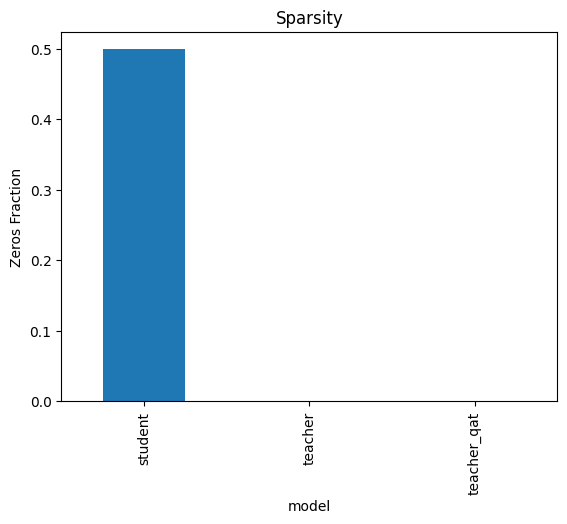


Resumen guardado en mnist_summaryMLP.csv


In [2]:
#!/usr/bin/env python3
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)


# === RUTA LOCAL (ajustada a tu PC) ===
MODEL_DIR = "models/MLP/"


model_files = {
    "student": os.path.join(MODEL_DIR, "studentModelMnistMLP.h5"),
    "teacher": os.path.join(MODEL_DIR, "teacherModelMnistMLP.h5"),
    "teacher_qat": os.path.join(MODEL_DIR, "teacherModelQATMnistMLP.h5")
}

# === Carga MNIST ===
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test_flat = x_test.reshape((x_test.shape[0], -1))

results = []

def safe_load_model(path):
    try:
        model = load_model(path,custom_objects=co)
        return model, None
    except Exception as e:
        return None, str(e)

for name, path in model_files.items():
    info = {"model": name, "path": path, "exists": os.path.exists(path)}

    if not os.path.exists(path):
        info["error"] = "file not found"
        results.append(info)
        continue

    info["filesize_bytes"] = os.path.getsize(path)

    model, err = safe_load_model(path)
    if err:
        info["error"] = f"load_error: {err}"
        results.append(info)
        continue

    info["loaded"] = True

    # Parámetros
    info["params_count"] = model.count_params()

    # Sparsity
    weights = model.get_weights()
    total = sum(w.size for w in weights)
    zeros = sum(np.sum(w == 0.0) for w in weights)

    info["weights_total"] = total
    info["weights_zeros"] = zeros
    info["sparsity_fraction"] = zeros / total

    # Evaluación
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    loss, acc = model.evaluate(x_test_flat, y_test, verbose=0)
    info["eval_loss"] = loss
    info["eval_accuracy"] = acc

    # Latencia
    model.predict(x_test_flat[:128], batch_size=128, verbose=0)
    t0 = time.time()
    model.predict(x_test_flat, batch_size=256, verbose=0)
    t1 = time.time()
    info["inference_time_total_s"] = t1 - t0
    info["inference_time_per_sample_ms"] = (t1 - t0) / len(x_test_flat) * 1000

    results.append(info)

# === DataFrame ===
df = pd.DataFrame(results)
print("\n=== Resumen ===")
print(df.to_string(index=False))

# === Gráficas ===
if "eval_accuracy" in df:
    df.set_index("model")["eval_accuracy"].plot(kind="bar",
                                                title="Accuracy MNIST")
    plt.ylabel("Accuracy")
    plt.show()

if "sparsity_fraction" in df:
    df.set_index("model")["sparsity_fraction"].plot(kind="bar",
                                                    title="Sparsity")
    plt.ylabel("Zeros Fraction")
    plt.show()

# === CSV ===
df.to_csv("mnist_summaryMLP.csv", index=False)
print("\nResumen guardado en mnist_summaryMLP.csv")



=== Resumen ===
      model                                  path  exists  filesize_bytes  loaded  params_count  weights_total  weights_zeros  sparsity_fraction  eval_loss  eval_accuracy  inference_time_total_s  inference_time_per_sample_ms
    student    models/CNN/studentModelMnistCNN.h5    True           53992    True          3816           3816           1853           0.485587   0.228930         0.9345                1.664796                      0.166480
    teacher    models/CNN/teacherModelMnistCNN.h5    True          108976    True          4746           4746              0           0.000000   0.282726         0.9504                0.494939                      0.049494
teacher_qat models/CNN/teacherModelQATMnistCNN.h5    True          122688    True          4746           4746              3           0.000632   0.192540         0.9463                1.626815                      0.162681


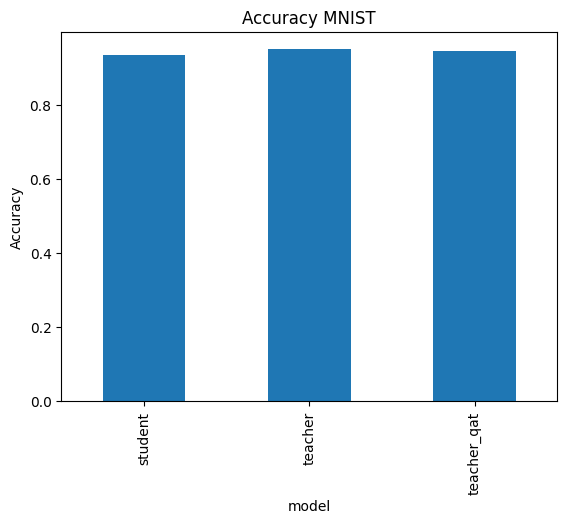

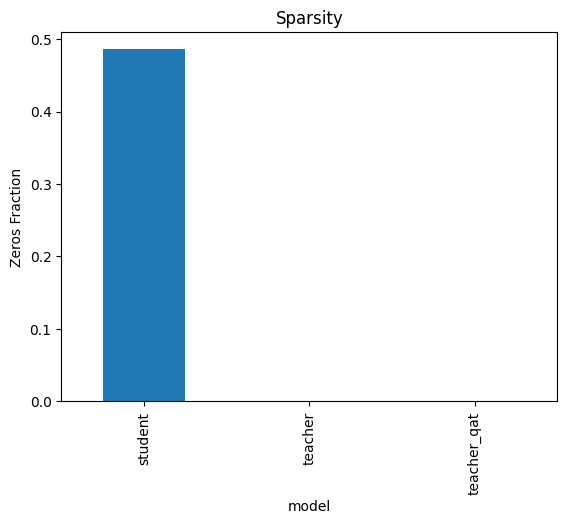


Resumen guardado en mnist_summaryCNN.csv


In [3]:
#!/usr/bin/env python3
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

# --- QKeras imports ---
from qkeras.utils import _add_supported_quantized_objects

# Registrar objetos cuantizados
co = {}
_add_supported_quantized_objects(co)


# === RUTA LOCAL (ajustada a tu PC) ===
MODEL_DIR = "models/CNN/"

model_files = {
    "student": os.path.join(MODEL_DIR, "studentModelMnistCNN.h5"),
    "teacher": os.path.join(MODEL_DIR, "teacherModelMnistCNN.h5"),
    "teacher_qat": os.path.join(MODEL_DIR, "teacherModelQATMnistCNN.h5")
}


# === Carga MNIST ===
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalización
x_test = x_test.astype("float32") / 255.0

# Añadir canal: (N, 28, 28, 1)
x_test = x_test[..., tf.newaxis]


# === Función de carga segura ===
def safe_load_model(path):
    try:
        model = load_model(path, custom_objects=co)
        return model, None
    except Exception as e:
        return None, str(e)


results = []

for name, path in model_files.items():

    info = {"model": name, "path": path, "exists": os.path.exists(path)}

    # Verificar archivo
    if not os.path.exists(path):
        info["error"] = "file not found"
        results.append(info)
        continue

    info["filesize_bytes"] = os.path.getsize(path)

    model, err = safe_load_model(path)
    if err:
        info["error"] = f"load_error: {err}"
        results.append(info)
        continue

    info["loaded"] = True

    # Parámetros
    info["params_count"] = model.count_params()

    # Sparsity
    weights = model.get_weights()
    total = sum(w.size for w in weights)
    zeros = sum(np.sum(w == 0.0) for w in weights)

    info["weights_total"] = total
    info["weights_zeros"] = zeros
    info["sparsity_fraction"] = zeros / total

    # Evaluación
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    info["eval_loss"] = loss
    info["eval_accuracy"] = acc

    # === Latencia ===
    # Calentamiento
    model.predict(x_test[:256], batch_size=256, verbose=0)

    t0 = time.time()
    model.predict(x_test, batch_size=256, verbose=0)
    t1 = time.time()

    info["inference_time_total_s"] = t1 - t0
    info["inference_time_per_sample_ms"] = (t1 - t0) / len(x_test) * 1000

    results.append(info)


# === DataFrame ===
df = pd.DataFrame(results)
print("\n=== Resumen ===")
print(df.to_string(index=False))


# === Gráficas ===
plt.figure()
df.set_index("model")["eval_accuracy"].plot(kind="bar", title="Accuracy MNIST")
plt.ylabel("Accuracy")
plt.show()

plt.figure()
df.set_index("model")["sparsity_fraction"].plot(kind="bar", title="Sparsity")
plt.ylabel("Zeros Fraction")
plt.show()


# === CSV ===
df.to_csv("mnist_summaryCNN.csv", index=False)
print("\nResumen guardado en mnist_summaryCNN.csv")


In [4]:
#!/usr/bin/env python3
import os

from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model  # <-- importante en algunas versiones

from qkeras.utils import _add_supported_quantized_objects

# Registrar capas cuantizadas
co = {}
_add_supported_quantized_objects(co)

# === Ruta local ===
MODEL_DIR = "models/CNN/"

model_files = {
    "studentModelMnistCNN.h5",
    "teacherModelMnistCNN.h5",
    "teacherModelQATMnistCNN.h5"
}

# === Crear carpeta outputs si no existe ===
OUTPUT_DIR = "model_plots/CNN"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def safe_load_model(path):
    try:
        model = load_model(path, custom_objects=co)
        return model, None
    except Exception as e:
        return None, str(e)

for filename in model_files:
    path = os.path.join(MODEL_DIR, filename)
    print(f"\nCargando modelo: {path}")

    model, err = safe_load_model(path)
    if err:
        print(f"Error al cargar {filename}: {err}")
        continue

    outpath = os.path.join(OUTPUT_DIR, filename.replace(".h5", ".png"))
    print(f"Generando diagrama: {outpath}")

    plot_model(
        model,
        to_file=outpath,
        show_shapes=True,
        show_layer_names=True,
        expand_nested=True,
        dpi=120
    )

print("\nListo ✔ Diagrama de modelos generado en carpeta 'model_plots'")



Cargando modelo: models/CNN/studentModelMnistCNN.h5


Generando diagrama: model_plots/CNN/studentModelMnistCNN.png

Cargando modelo: models/CNN/teacherModelMnistCNN.h5
Generando diagrama: model_plots/CNN/teacherModelMnistCNN.png

Cargando modelo: models/CNN/teacherModelQATMnistCNN.h5
Generando diagrama: model_plots/CNN/teacherModelQATMnistCNN.png

Listo ✔ Diagrama de modelos generado en carpeta 'model_plots'


/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(



=== RESUMEN MODELOS CNN ===
      model                                  path  exists  filesize_bytes  filesize_mb  loaded  params_count  weights_total  weights_zeros  sparsity_fraction  eval_loss  eval_accuracy flops_total  inference_time_total_s  inference_time_per_sample_ms  params_ratio_vs_teacher  acc_drop_vs_teacher  speedup_vs_teacher  sparsity_vs_teacher  size_ratio_vs_teacher
    student    models/CNN/studentModelMnistCNN.h5    True          273720     0.261040    True         58474          58474          29160           0.498683   0.362727         0.8927        None                1.557590                      0.155759                 0.258746              -0.0966            0.595304             0.498670               0.099024
    teacher    models/CNN/teacherModelMnistCNN.h5    True         2764184     2.636131    True        225990         225990              3           0.000013   0.070524         0.9893        None                0.927239                      0.092724  

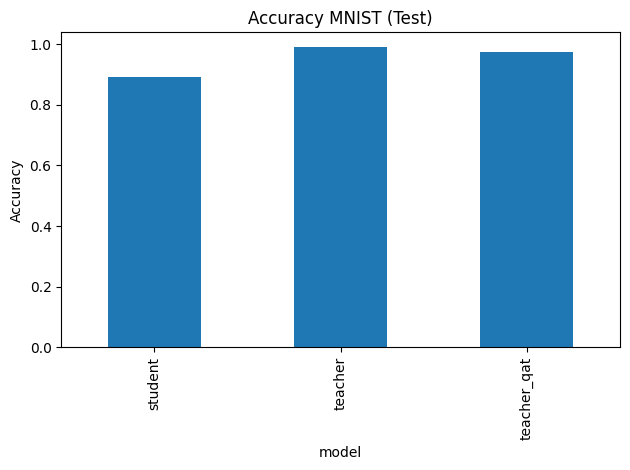

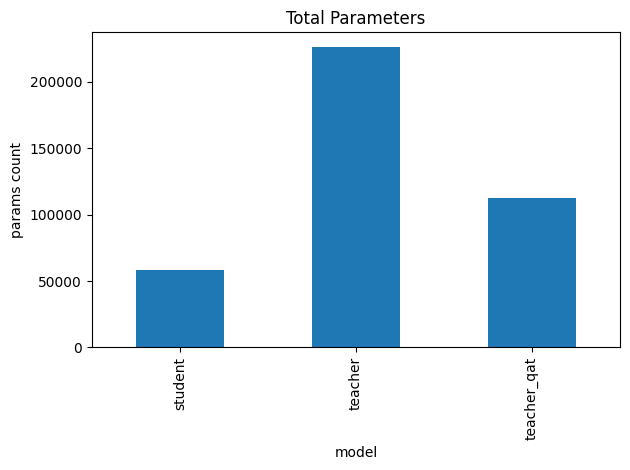

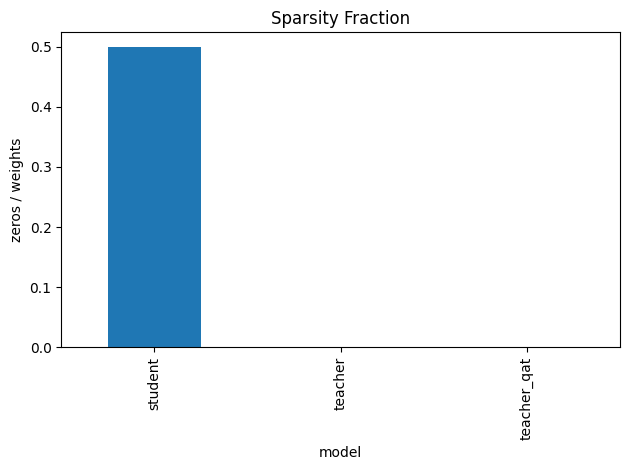

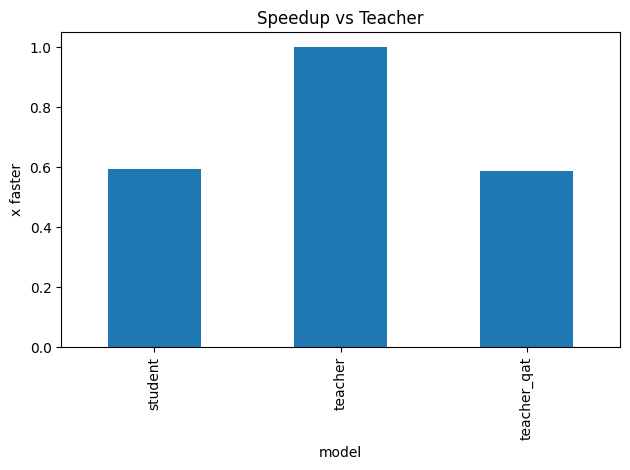

In [3]:
#!/usr/bin/env python3
"""
Comparación entre modelos Teacher y Student para MNIST-CNN
Métricas:
- Accuracy
- Loss
- Parámetros totales
- Sparsity (fracción de ceros)
- Tamaño en disco
- FLOPs aproximados
- Latencia por muestra
- Speedup relativo
- Comparación porcentual con Teacher
"""

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

# --- QKeras imports ---
from qkeras.utils import _add_supported_quantized_objects

# Registrar objetos cuantizados
co = {}
_add_supported_quantized_objects(co)


# === RUTA LOCAL (ajustada a tu PC) ===
MODEL_DIR = "models/CNN/"

model_files = {
    "student": os.path.join(MODEL_DIR, "studentModelMnistCNN.h5"),
    "teacher": os.path.join(MODEL_DIR, "teacherModelMnistCNN.h5"),
    "teacher_qat": os.path.join(MODEL_DIR, "teacherModelQATMnistCNN.h5")
}


# === Carga MNIST ===
(_, _), (x_test, y_test) = mnist.load_data()

# Normalización
x_test = x_test.astype("float32") / 255.0

# Añadir canal: (N, 28, 28, 1)
x_test = x_test[..., tf.newaxis]


# === Función de carga segura ===
def safe_load_model(path):
    try:
        model = load_model(path, custom_objects=co)
        return model, None
    except Exception as e:
        return None, str(e)


# === FLOPs aproximados (Keras) ===
def count_flops(model):
    """
    Cálculo aproximado usando TF2 profiler.
    No es exacto pero sirve para comparaciones relativas.
    """
    try:
        concrete = tf.function(model).get_concrete_function(
            tf.TensorSpec([1, 28, 28, 1], model.inputs[0].dtype)
        )
        frozen_func, graph_def = tf.graph_util.convert_variables_to_constants_v2_as_graph(concrete)
        flops = tf.compat.v1.profiler.profile(
            graph=frozen_func.graph,
            options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        )
        return flops.total_float_ops
    except:
        return None


results = []

for name, path in model_files.items():

    info = {"model": name, "path": path, "exists": os.path.exists(path)}

    if not os.path.exists(path):
        info["error"] = "NOT FOUND"
        results.append(info)
        continue

    info["filesize_bytes"] = os.path.getsize(path)

    # Tamaño del modelo
    info["filesize_mb"] = info["filesize_bytes"] / (1024 * 1024)


    model, err = safe_load_model(path)
    if err:
        info["error"] = f"ERROR: {err}"
        results.append(info)
        continue

    info["loaded"] = True

    # Parámetros
    info["params_count"] = model.count_params()

    # Sparsity
    weights = model.get_weights()
    total = sum(w.size for w in weights)
    zeros = sum(np.sum(w == 0.0) for w in weights)
    info["weights_total"] = total
    info["weights_zeros"] = zeros
    info["sparsity_fraction"] = zeros / total

    # Evaluación
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    info["eval_loss"] = loss
    info["eval_accuracy"] = acc

    # FLOPs
    flops = count_flops(model)
    info["flops_total"] = flops

    # Latencia
    model.predict(x_test[:64], verbose=0)  # warm up
    t0 = time.time()
    model.predict(x_test, batch_size=256, verbose=0)
    t1 = time.time()

    info["inference_time_total_s"] = t1 - t0
    info["inference_time_per_sample_ms"] = (t1 - t0) / len(x_test) * 1000

    results.append(info)


# === DataFrame ===
df = pd.DataFrame(results)

# referencia Teacher para porcentajes
teacher = df[df.model == "teacher"].iloc[0]

# comparación relativa
df["params_ratio_vs_teacher"] = df.params_count / teacher.params_count
df["acc_drop_vs_teacher"] = df.eval_accuracy - teacher.eval_accuracy
df["speedup_vs_teacher"] = teacher.inference_time_per_sample_ms / df.inference_time_per_sample_ms
df["sparsity_vs_teacher"] = df.sparsity_fraction - teacher.sparsity_fraction
# Comparación relativa frente al teacher
teacher = df[df.model == "teacher"].iloc[0]

df["size_ratio_vs_teacher"] = df.filesize_mb / teacher.filesize_mb


df.to_csv("mnist_summaryCNN.csv", index=False)

print("\n=== RESUMEN MODELOS CNN ===")
print(df.to_string(index=False))


# === Gráficas para presentación ===

# Accuracy
plt.figure()
df.set_index("model")["eval_accuracy"].plot(kind="bar", title="Accuracy MNIST (Test)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("plot_accuracy.png")

# Parámetros
plt.figure()
df.set_index("model")["params_count"].plot(kind="bar", title="Total Parameters")
plt.ylabel("params count")
plt.tight_layout()
plt.savefig("plot_params.png")

# Sparsity
plt.figure()
df.set_index("model")["sparsity_fraction"].plot(kind="bar", title="Sparsity Fraction")
plt.ylabel("zeros / weights")
plt.tight_layout()
plt.savefig("plot_sparsity.png")

# Speedup
plt.figure()
df.set_index("model")["speedup_vs_teacher"].plot(kind="bar", title="Speedup vs Teacher")
plt.ylabel("x faster")
plt.tight_layout()
plt.savefig("plot_speedup.png")

print("\nGráficas guardadas:")
print("- plot_accuracy.png")
print("- plot_params.png")
print("- plot_sparsity.png")
print("- plot_speedup.png")
print("\nCSV: mnist_summaryCNN.csv")
